In [24]:
from config import Config
from model.pytorch_models.cnn import CNN
from model.pytorch_models.cvt import ConvolutionalVisionTransformer, QuickGELU, LayerNorm
from model.pytorch_models.rvt import ResidualVisionTransformer, DeepFEC_v2_vehicle_config_model, DeepFEC_v2_vehicle_config_model_2
from __init__ import get_train_test_data
import torch
from torch import nn
from torchsummary import summary
import numpy as np
from functools import partial
from model.metrics import rmse, mape, mae, get_model_save_path
import tensorwatch as tw
import os
import matplotlib.pyplot as plt 

In [25]:
torch.manual_seed(50)

conf = Config("config_fig.yaml")
print(conf.observe_length)

12


In [26]:
# PREPARE DATA
data, arm_shape, train_xs, train_ys, train_arms, train_xp, train_xt, train_xe,\
    train_vehicle_type, train_engine_config, train_gen_weight,\
    test_xs, test_ys, test_arms, test_xp, test_xt, test_xe,\
    test_vehicle_type, test_engine_config, test_gen_weight = \
    get_train_test_data(conf, need_road_network_structure_matrix=True)  # \
print('************** Train - Predict **********')
print('train_xs:', train_xs.shape,  'test_xs:', test_xs.shape, 'train_xp:', train_xp.shape, 'test_xp:',
      test_xp.shape, 'test_xe:', test_xe.shape, 'train_ys:', train_ys.shape, 'test_ys:', test_ys.shape)
print(train_vehicle_type.shape, train_engine_config.shape, train_gen_weight.shape)


complete start
Start load_raw_link_speed_by_road_in_time ing..
speed items 363996
load from raw finish
function load_raw_link_speed_by_road cost 1.6396467685699463 s
preprocess finish
function load_raw_link_speed_by_road_in_time cost 1.6396467685699463 s
complete finish
STM  SHAPE(edges, timeslots)  13*28=  #######  (955, 364)
ARM  SHAPE(edges, A) ####### (955, 5)
T  SHAPE ####### 364
function completion_data cost 3.4991936683654785 s
****************** External Information ****************************
holiday shape (364, 1)
vec shape (day of week 7, weekend/weekday 1, hour of day 13 (364, 21)
External data shape (364, 22)
*********************************************************************
YS shape(,edges,predict_length) (364, 955, 1)
externel_data weather and holidays E.shape(,predict_length,) (364, 1, 22)
****************** Periodicity  Information ****************************
In-day periodicity XC.shape(nb_days,edges,timeslots_in_day) (28, 955, 12, 2)
Weekly periodicity XP.shape(4

In [27]:
if conf.use_vehicle_info:
    train_xs = np.concatenate((train_xs, train_vehicle_type, train_engine_config, train_gen_weight), axis = 3)
    test_xs = np.concatenate((test_xs, test_vehicle_type, test_engine_config, test_gen_weight), axis = 3)

## USE HOLIDAY INFO (train_xe)
# Repeat the last part along axis=1 to match a shape of (23, 955, 22)
train_xe = np.tile(train_xe[:, -1:], (1, 955, 1))
test_xe = np.tile(test_xe[:, -1:], (1, 955, 1))


In [28]:
model = None
if conf.model_name == 'CVT':
    model = ConvolutionalVisionTransformer(
        in_chans=1,
        num_classes=1,
        act_layer=QuickGELU,
        norm_layer=partial(LayerNorm, eps=1e-5),
        spec=conf.cvt_spec
    )
else:
    print("using DeepFEC_v2_vehicle_config_model")
    model = DeepFEC_v2_vehicle_config_model_2(
        in_chans=1,
        num_classes=1,
        act_layer=QuickGELU,
        norm_layer=partial(LayerNorm, eps=1e-5),
        spec=conf.cvt_spec
    )

using DeepFEC_v2_vehicle_config_model


In [29]:

# Define hyperparameters
n_epochs = conf.epochs
lr=0.01

# Define Loss, Optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [30]:
# summary(model, (12, 5, 1), 955)
# Define lists to store training and validation losses
train_losses = []
val_losses = []

In [33]:

## TRAIN
for epoch in range(n_epochs + 1):  # loop over the dataset multiple times
    count = 0
    losses_t = []
    
    for i in range(train_xs.shape[0]):
        # get the inputs; data is a list of [inputs, labels]
        inputs = torch.from_numpy(train_xs[i]).float()
        holiday_inputs = torch.from_numpy(train_xe[i]).float()
        values = torch.from_numpy(train_ys[i]).float()
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        # print("input :" , inputs.shape)
        outputs = model(inputs, holiday_inputs)

        loss = criterion(outputs, values)
        losses_t.append(loss.item())
        count += 1
        loss.backward()
        optimizer.step()

        # print statistics
        print('Epoch: {}/{}.............'.format(epoch, n_epochs), end=' ')
        print("Loss: {:.8f}".format(loss.item()))
        
    sum = 0
    for loss in losses_t:
        sum = sum + loss
    loss_per_epoch = sum / count
    train_losses.append(loss_per_epoch)
    
    losses_v = []
    sum = 0
    count = 0
    for j in range(test_xs.shape[0]):
        t_inputs = torch.from_numpy(test_xs[j]).float()
        h_inputs = torch.from_numpy(test_xe[j]).float()
        t_values = torch.from_numpy(test_ys[j]).float()
        predicted = model(t_inputs, h_inputs)
        loss = criterion(predicted, t_values)
        losses_v.append(loss.item())
        count += 1

    for loss in losses_v:
        sum = sum + loss
    loss_per_epoch = sum / count
    val_losses.append(loss_per_epoch)
        
print('Finished Training, starting testing')


Epoch: 0/40............. Loss: 0.00414772
Epoch: 0/40............. Loss: 0.00393892
Epoch: 0/40............. Loss: 0.00354156
Epoch: 0/40............. Loss: 0.00341996
Epoch: 0/40............. Loss: 0.00340717
Epoch: 0/40............. Loss: 0.00324653
Epoch: 0/40............. Loss: 0.00333456
Epoch: 0/40............. Loss: 0.00287840
Epoch: 0/40............. Loss: 0.00299857
Epoch: 0/40............. Loss: 0.00320279
Epoch: 0/40............. Loss: 0.00311242
Epoch: 0/40............. Loss: 0.00252933
Epoch: 0/40............. Loss: 0.00251138
Epoch: 0/40............. Loss: 0.00243401
Epoch: 0/40............. Loss: 0.00227769
Epoch: 0/40............. Loss: 0.00254773
Epoch: 0/40............. Loss: 0.00258209
Epoch: 0/40............. Loss: 0.00253621
Epoch: 0/40............. Loss: 0.00269384
Epoch: 0/40............. Loss: 0.00302761
Epoch: 0/40............. Loss: 0.00275137
Epoch: 0/40............. Loss: 0.00246473
Epoch: 0/40............. Loss: 0.00217698
Epoch: 1/40............. Loss: 0.0

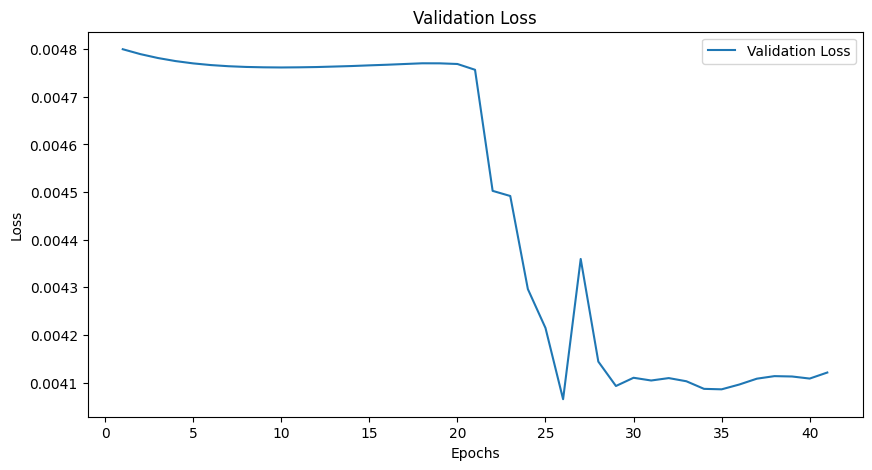

In [46]:
plt.figure(figsize=(10, 5))
# plt.plot(range(1, 41), train_losses[:40], label='Training Loss')
plt.plot(range(1, len(val_losses)+1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation Loss')
plt.legend()
plt.show()

In [37]:
print(len(train_losses))

82


In [21]:
print(train_xs.shape[0])

23
